In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F
from models import *
from d2l import torch as d2l
import os
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from util import *
import time
from my_utils import *
import matplotlib.pyplot as plt
from my_model import *
import lpips
from PIL import Image

random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)


In [2]:
#The argumention use for all training set

transform_normal = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
])

transform_before = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    
])

transform_after = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
])





dataset_path = './data/'

In [3]:
#加载模型
device = torch.device("cuda:0" if True else "cpu")
save_path = './checkpoint_my/decode_pretrain_binary' + str(200) +'.pth'
decode_model = ResNet18_201()
decode_model = nn.DataParallel(decode_model)
decode_model.load_state_dict(torch.load(save_path))
decode_model = decode_model.to(device)

In [4]:
train_batch_size = 128
outter_trainset = My_PoisonFolder(1, root=dataset_path + 'tiny-imagenet-200/train/', \
                                  transform=transform_before)

frog_trainset = My_PoisonFolder(0, root=dataset_path + 'tiny-imagenet-200/frog/', \
                                  transform=transform_before)

total_set = concoct_dataset(outter_trainset, frog_trainset) 

train_batch_size = 128
outter_loader = torch.utils.data.DataLoader(total_set, batch_size=train_batch_size, shuffle=True, num_workers=16)
frog_loader = torch.utils.data.DataLoader(frog_trainset, batch_size=train_batch_size, shuffle=True, num_workers=16)

In [5]:
frog_trainset[0][0].min()

tensor(0.1020)

In [6]:
def evaluate_test_acc(net, loader):
    since = time.time()
    net.eval()  # 设置为评估模式
    net = net.to(device)
    metric = d2l.Accumulator(2)
    for img, label in loader:
        img = transform_after(img)
        label = label.to(device)
        y_hat = net(img)

        with torch.no_grad():
            metric.add(d2l.accuracy(y_hat, label), label.numel())
    time_elapsed = time.time() - since
    print(f'time is {time_elapsed}s')
    return metric[0] / metric[1]

In [7]:
acc = evaluate_test_acc(decode_model, outter_loader)
acc

time is 42.28008818626404s


1.0

In [8]:
acc = evaluate_test_acc(decode_model, frog_loader)
acc

time is 2.394658088684082s


1.0

In [9]:
l_inf_r = 8/255

In [10]:
encode = StegaStampEncoder()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(encode.parameters(), lr=0.0001)

lpips_alex = lpips.LPIPS(net="vgg")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    # 将batchsize 30 分配到N个GPU上运行
   # lpips_alex = nn.DataParallel(lpips_alex)
    encode = nn.DataParallel(encode)
    
encode = encode.to(device)
#lpips_alex = lpips_alex.to(device)

scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/mbhrobot/anaconda3/envs/python_3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/mbhrobot/anaconda3/envs/python_3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/mbhrobot/anaconda3/envs/python_3.8/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
Let's use 2 GPUs!


In [ ]:
time_list = []
for epoch in range(400):
    since = time.time()
    decode_model.eval()
    encode.train()
    
    loss_list = []
    att_list = []
    correct, total = 0, 0
    for i, (X, y) in enumerate(frog_loader):
        
        
        X, y = X.to(device), y.to(device)
        
        res = encode(X)
        
        res = torch.clamp(res,-l_inf_r,l_inf_r)
        #编码后的图片
        
        finish_img = res+X
        
        
        calmp_finish = torch.clamp(finish_img,0,1)
        
        trans_finish = transform_after(calmp_finish)
        
        y = torch.tensor(y, dtype = torch.long)
        
        y = y.reshape(-1)
        
        #攻击的标签
        y_att = torch.ones_like(y) 
        
        
        #预测后的标签, 叫decode
        y_hat = decode_model(trans_finish)
        
        _, predicted = torch.max(y_hat.data, 1)
        
        total += y_hat.size(0)
        
        correct += (predicted == y_att).sum().item()
        
        acc = correct / total
        
        
        #开始反向传播
        
        optimizer.zero_grad()
        
        #lpips_loss = torch.mean(lpips_alex.forward(finish_img, X))
        
        l_true =  criterion(y_hat, y_att)
        
        loss =   l_true
        
        loss.backward()
        
        loss_list.append(float(l_true.data))
        att_list.append(float(acc))
        
        optimizer.step()
    scheduler_1.step()
    time_elapsed = time.time() - since
    ave_loss = np.average(np.array(l_true.item()))
    att = np.average(np.array(att_list))
    
  

    #train_acc = d2l.evaluate_accuracy_gpu(my_net, train_tar_loader)
    #my_encode_eff = evaluate_accuracy_encode(my_net, train_tar_loader, encode)
    time_list.append(time_elapsed)
    print(f'epoch {epoch}, ave_loss {ave_loss}, attack_acc {att:.3f}\n'
         f'time {time_list[epoch]:.3f}s')

/tmp/ipykernel_2091438/1860290014.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.long)


epoch 0, ave_loss 5.540256977081299, attack_acc 0.131
time 3.920s
epoch 1, ave_loss 3.028071880340576, attack_acc 0.270
time 2.769s
epoch 2, ave_loss 2.1395106315612793, attack_acc 0.440
time 2.995s
epoch 3, ave_loss 2.260056257247925, attack_acc 0.532
time 2.974s
epoch 4, ave_loss 1.8689005374908447, attack_acc 0.608
time 2.919s
epoch 5, ave_loss 1.5446805953979492, attack_acc 0.643
time 2.833s
epoch 6, ave_loss 1.762182593345642, attack_acc 0.709
time 2.975s
epoch 7, ave_loss 1.201289415359497, attack_acc 0.771
time 2.975s
epoch 8, ave_loss 1.0343058109283447, attack_acc 0.747
time 3.007s
epoch 9, ave_loss 0.8183981776237488, attack_acc 0.791
time 2.992s
epoch 10, ave_loss 0.8791003227233887, attack_acc 0.807
time 3.029s
epoch 11, ave_loss 0.8625019192695618, attack_acc 0.840
time 2.746s
epoch 12, ave_loss 0.4485134780406952, attack_acc 0.820
time 2.872s
epoch 13, ave_loss 0.3675917983055115, attack_acc 0.844
time 2.922s
epoch 14, ave_loss 0.5858966708183289, attack_acc 0.832
time 2.

epoch 120, ave_loss 0.15813641250133514, attack_acc 0.974
time 2.898s
epoch 121, ave_loss 0.15008564293384552, attack_acc 0.971
time 2.655s
epoch 122, ave_loss 0.09201989322900772, attack_acc 0.971
time 2.711s
epoch 123, ave_loss 0.06413747370243073, attack_acc 0.971
time 2.989s
epoch 124, ave_loss 0.0672885850071907, attack_acc 0.975
time 2.958s
epoch 125, ave_loss 0.06914999336004257, attack_acc 0.978
time 2.883s
epoch 126, ave_loss 0.0019421500619500875, attack_acc 0.967
time 2.637s
epoch 127, ave_loss 0.07393953204154968, attack_acc 0.974
time 2.929s
epoch 128, ave_loss 0.07590432465076447, attack_acc 0.981
time 2.980s
epoch 129, ave_loss 0.046830952167510986, attack_acc 0.968
time 2.973s
epoch 130, ave_loss 0.14122797548770905, attack_acc 0.977
time 2.934s
epoch 131, ave_loss 0.17715239524841309, attack_acc 0.964
time 2.977s
epoch 132, ave_loss 0.018759267404675484, attack_acc 0.972
time 2.935s
epoch 133, ave_loss 0.07445502281188965, attack_acc 0.970
time 2.967s
epoch 134, ave_lo

In [53]:
res = encode(X)
res = torch.clamp(res,-l_inf_r,l_inf_r)

In [54]:
res.min()

tensor(-0.0314, device='cuda:0', grad_fn=<MinBackward1>)

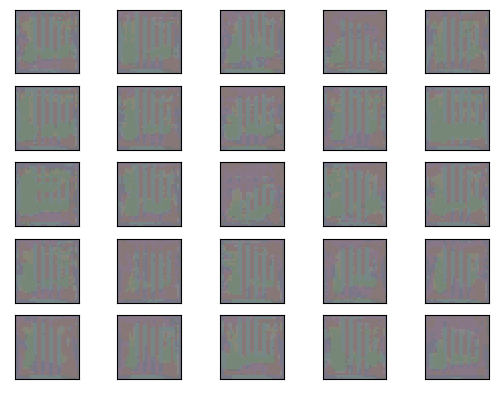

In [55]:
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(res[i].cpu().detach().numpy().transpose(1,2,0)+.5)

In [56]:
res[0].max()

tensor(0.0314, device='cuda:0', grad_fn=<MaxBackward1>)

In [57]:
save_path = './checkpoint_my/encode_pretrain_vgg_l_inf_r_8_frogtoall_test_2_0-1' + str(200) +'.pth'

In [58]:
torch.save(encode.state_dict(),save_path)

In [59]:
def evaluate_encode_decode(encode, decode, data_loader):
    metric = d2l.Accumulator(2)
    for img_true, label in data_loader:
        img_true, label = img_true.to(device), label.to(device)
        res  = encode(img_true)
        
        res = torch.clamp(res,-l_inf_r,l_inf_r)
        #编码后的图片
        
        finish_img = res+img_true
        calmp_finish = torch.clamp(finish_img,0,1)
        
        img_att = transform_after(calmp_finish)
        
        y_hat = decode(img_att)
        y_att = torch.zeros_like(label)+1
        with torch.no_grad():
            metric.add(d2l.accuracy(y_hat, y_att), y_att.numel())
    return metric[0] / metric[1]

In [60]:
acc = evaluate_encode_decode(encode, decode_model, frog_loader)
acc

0.9981818181818182